In [114]:
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix
import numpy as np
import pandas as pd
import seaborn as sns
import tcri
from genevector.data import GeneVectorDataset
from genevector.model import GeneVector
from genevector.embedding import GeneEmbedding, CellEmbedding
import grimoire as spell

## Configuration

In [115]:
#any without signed mi were  false
disease            = "bcc"
subset             = "CD8"
signed_mi          = True
init_ortho         = True
entropy_threshold  = 1.5
mutual_information = "/Users/ceglian/{}_{}_{}_{}.p".format(disease,subset,signed_mi,str(entropy_threshold).replace(".",""))
print(mutual_information)
adata_h5ad         = "/Users/ceglian/Data/tcri/yost.h5ad"
embedding_size     = 100
alpha              = 0.089611
beta               = 0.02399
gain               = 29
vector_file        = "/Users/ceglian/Data/tcri/{}_{}_{}_{}_{}_{}_{}_{}.vec".format(disease,embedding_size, alpha, beta, gain, subset, signed_mi, init_ortho)
print(vector_file)
retrain            = False
annotated_h5ad     = "/Users/ceglian/Data/tcri/{}_{}_annoated.h5ad".format(disease,subset)
device             = "cpu"


cd8 = ['CD8_act',
        'CD8_eff',
        'CD8_ex',
        'CD8_ex_act',
        'CD8_mem']
cd4 = ['Naive',
        'Tfh',
        'Th17',
        'Tregs']

/Users/ceglian/bcc_CD8_True_15.p
/Users/ceglian/Data/tcri/bcc_100_0.089611_0.02399_29_CD8_True_True.vec


## Read BCC data

In [116]:
adata = sc.read(adata_h5ad)
adata.X = csr_matrix(adata.X)
adata = adata[adata.obs["disease"] == "bcc"]
adata = spell.pp.remove_meaningless_genes(adata)
tcri.pp.register_clonotype_key(adata,"trb")
adata = adata[adata.obs[adata.uns["tcri_clone_key"]]!="None"]
if subset == "CD8":
    adata = adata[adata.obs["cluster"].isin(cd8)]
else:
    adata = adata[adata.obs["cluster"].isin(cd4)]
adata
tcri.pp.gene_entropy(adata)
adata = adata[:,adata.var["entropy"] > 1.5]
adata
dataset = GeneVectorDataset(adata,load_expression=True,signed_mi=signed_mi,device=device)

100%|██████████| 15943/15943 [00:01<00:00, 8635.05it/s]


Running...
Loading Expression.
Indexing expression.


100%|██████████| 2276659/2276659 [00:01<00:00, 1987688.77it/s]

Finished.


In [117]:
tcri.pp.gene_entropy(adata)
adata = adata[:,adata.var["entropy"] > 1.5]
adata

100%|██████████| 419/419 [00:00<00:00, 5460.28it/s]


View of AnnData object with n_obs × n_vars = 9563 × 419
    obs: 'cell.id', 'patient', 'treatment', 'cluster', 'UMAP1', 'UMAP2', 'trb', 'trb2', 'disease', 'response'
    var: 'entropy'
    uns: 'cluster_colors', 'tcri_clone_key', 'tcri_unique_clonotypes'
    obsm: 'X_umap'

In [160]:
dataset = GeneVectorDataset(adata,load_expression=False,signed_mi=signed_mi,device=device)
vector_file = "bcc_100_0.0006615414710573142_0.06309411774022254_16_CD8_True_True.vec"
embed = GeneEmbedding(vector_file, dataset, vector="average")
cembed = CellEmbedding(dataset, embed)
cembed.batch_correct(reference="su009",column="patient")
adata = cembed.get_adata()
adata

Running...
Skipping expression load.
Loading average of 1st and 2nd weights.


100%|██████████| 371/371 [00:00<00:00, 2725195.77it/s]


100%|██████████| 2276659/2276659 [00:03<00:00, 632275.36it/s]


Generating Cell Vectors.


100%|██████████| 9563/9563 [00:00<00:00, 12018.57it/s]


Found 0 Cells with No Counts.
Finished.
Generating batch vectors.
Computing correction vector for su001.
Computing correction vector for su002.
Computing correction vector for su003.
Computing correction vector for su004.
Computing correction vector for su005.
Computing correction vector for su006.
Computing correction vector for su007.
Computing correction vector for su008.
Computing correction vector for su010.
Computing correction vector for su012.
Applying correction vectors.
Loading embedding in X_genevector.
Running Scanpy neighbors and umap.


AnnData object with n_obs × n_vars = 9563 × 419
    obs: 'cell.id', 'patient', 'treatment', 'cluster', 'UMAP1', 'UMAP2', 'trb', 'trb2', 'disease', 'response', 'genevector', 'Size', 'TCR Sequence', 'Memory Similarity', 'Memory Module Score', 'Activated Similarity', 'Activated Module Score', 'Dysfunctional Similarity', 'Dysfunctional Module Score', 'clone_size', 'Memory Pseudo-probability', 'Activated Pseudo-probability', 'Dysfunctional Pseudo-probability'
    var: 'entropy'
    uns: 'cluster_colors', 'tcri_clone_key', 'tcri_unique_clonotypes', 'neighbors', 'umap', 'log1p', 'probability_columns', 'patient_colors', 'genevector_colors', 'tcri_unique_phenotypes', 'tcri_phenotype_key', 'rank_genes_groups', 'dendrogram_genevector'
    obsm: 'X_umap', 'X_genevector', 'X_pca'
    obsp: 'distances', 'connectivities'

In [162]:
set(adata.obs["patient"])

{'su001',
 'su002',
 'su003',
 'su004',
 'su005',
 'su006',
 'su007',
 'su008',
 'su009',
 'su010',
 'su012'}

In [163]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

In [164]:
# from sklearn.metrics import accuracy_score
# sc.tl.rank_genes_groups(adata,"cluster")
# markers = dict()
# sc.tl.rank_genes_groups(adata,"cluster")
# for x in set(adata.obs['cluster']):
#     markers[x] = sc.get.rank_genes_groups_df(adata,x)["names"].tolist()[:70]
# adata, dist = cembed.phenotype_probability(adata, markers, method="normalized_exponential",temperature=0.03, return_distances=True)
# accuracy_score(adata.obs["cluster"].tolist(), adata.obs["genevector"])
markers = dict()
# markers["Naive"] = ["IL7R"]
markers["Memory"] = ["GZMK"]
markers["Activated"] = ["GZMB"]
markers["Dysfunctional"] = ["CXCL13"]
adata, dist = cembed.phenotype_probability(adata, markers, method="normalized_exponential", return_distances=True)

Using Normalized Exponential (Temp: 0.05)
Computing similarities for Memory
Markers: GZMK


100%|██████████| 9563/9563 [00:00<00:00, 66720.11it/s]


Computing similarities for Activated
Markers: GZMB


100%|██████████| 9563/9563 [00:00<00:00, 68561.28it/s]


Computing similarities for Dysfunctional
Markers: CXCL13


100%|██████████| 9563/9563 [00:00<00:00, 69695.66it/s]


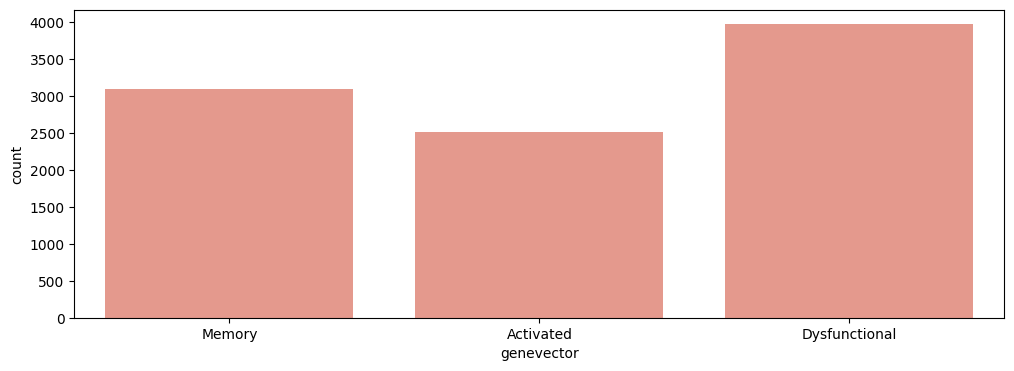

In [165]:
#order = list(set(adata.obs["cluster"]))
fig,ax=plt.subplots(1,1,figsize=(12,4))
sns.countplot(data=adata.obs, x="genevector",ax=ax)
plt.savefig("/Users/ceglian/gv_counts.pdf")

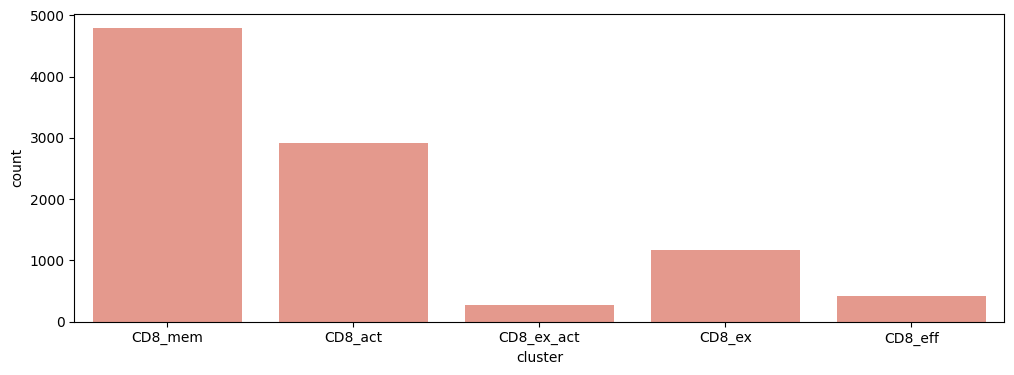

In [166]:
fig,ax=plt.subplots(1,1,figsize=(12,4))
sns.countplot(data=adata.obs, x="cluster",ax=ax,order=order)
plt.savefig("/Users/ceglian/orig_counts.pdf")

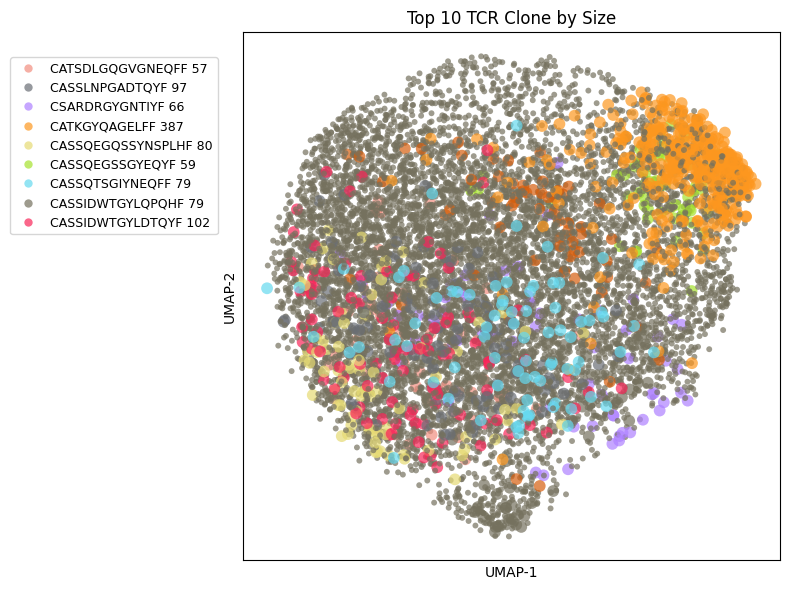

In [167]:
tcri.pl.clone_umap(adata,figsize=(8,6))

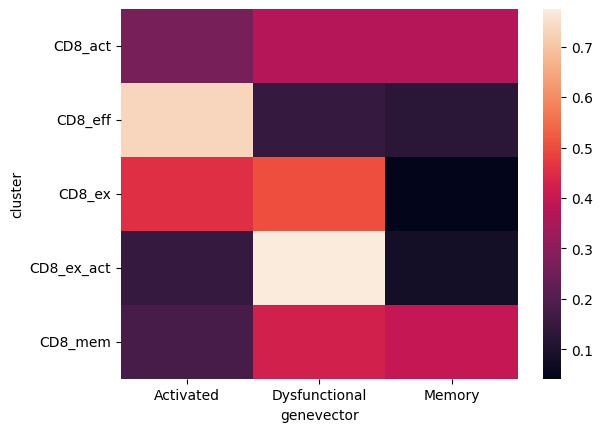

In [168]:

cembed.compare_classification(adata,"cluster","genevector")
plt.savefig("/Users/ceglian/acc.pdf")

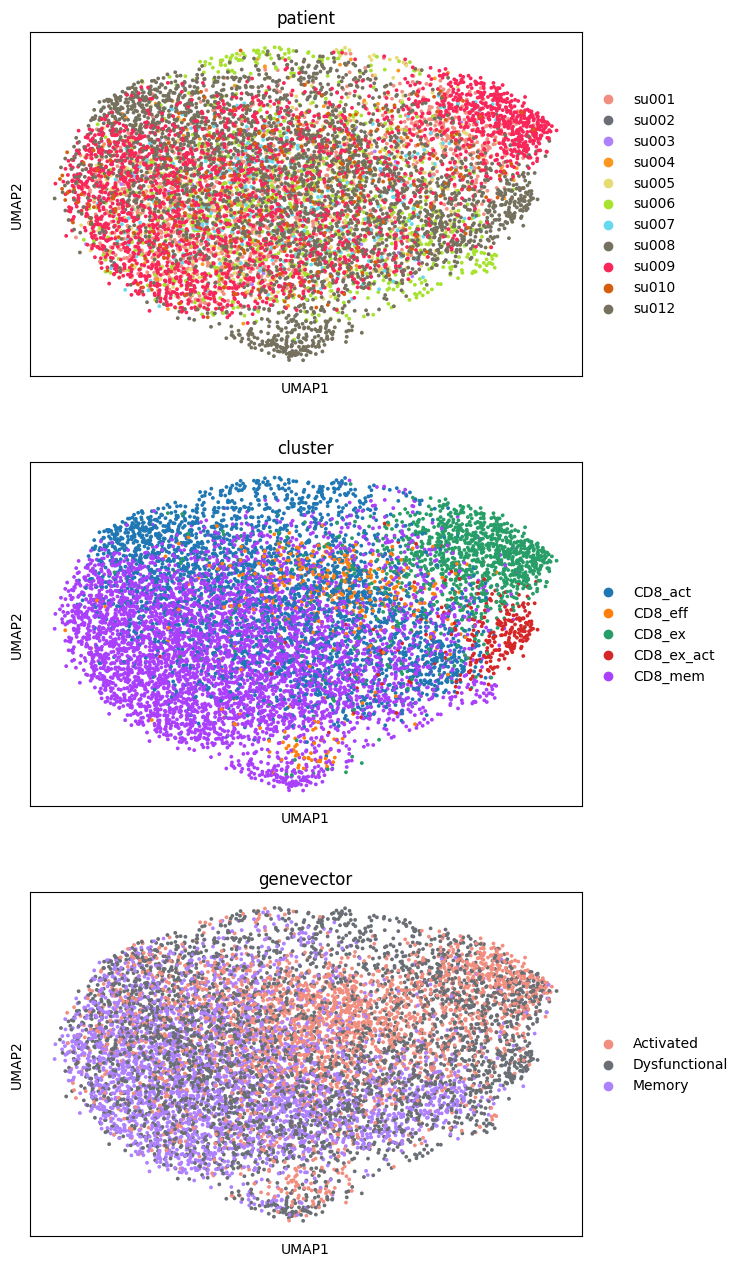

<Figure size 640x480 with 0 Axes>

In [169]:
sc.pl.umap(adata,color=["patient","cluster","genevector"],s=30,wspace=0.2, ncols=1)
plt.savefig("/Users/ceglian/gvumap.pdf")

100%|██████████| 9563/9563 [00:00<00:00, 74250.93it/s]


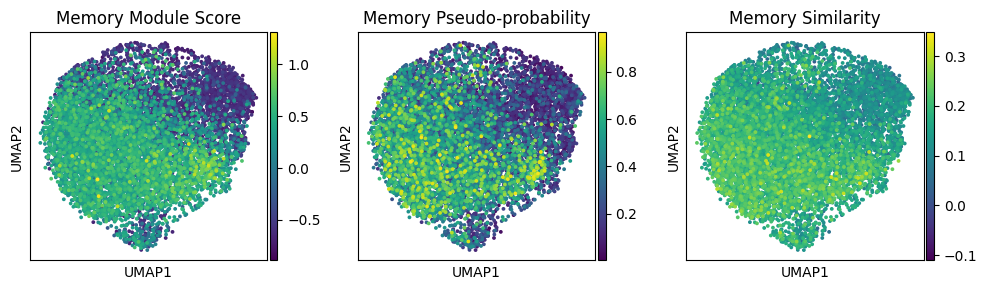

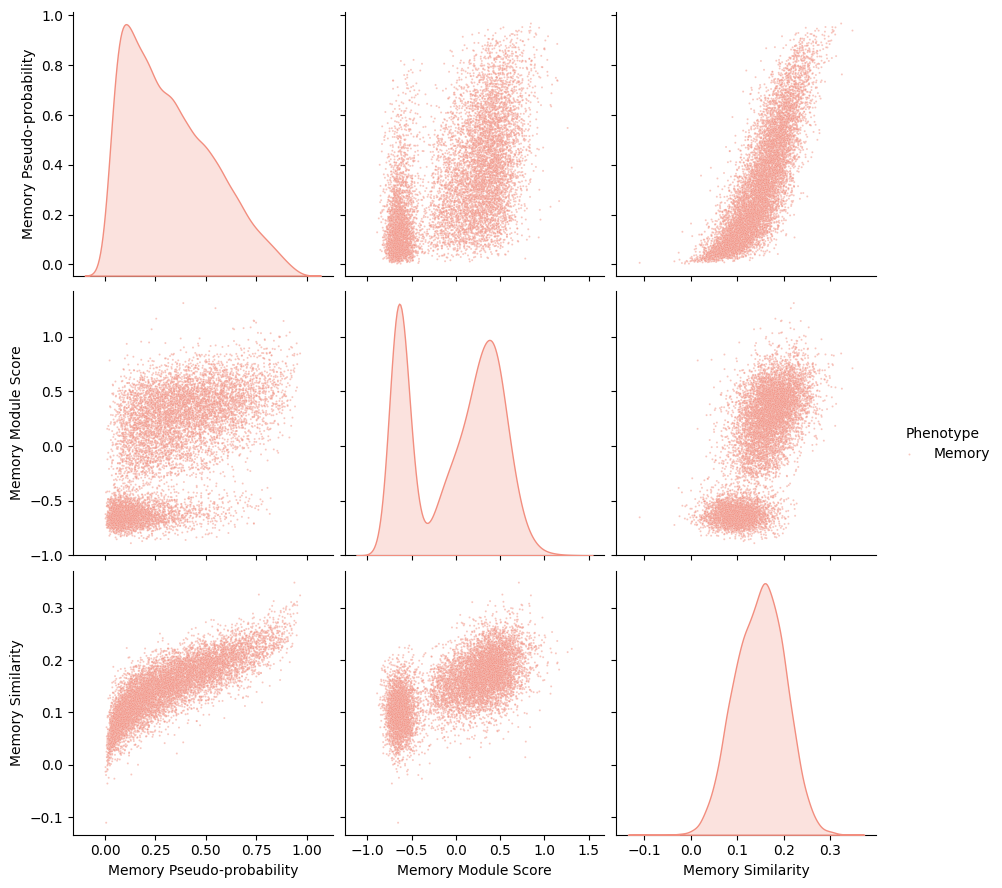

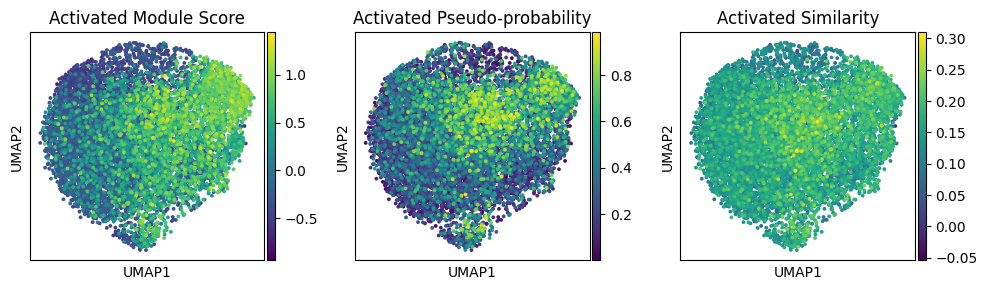

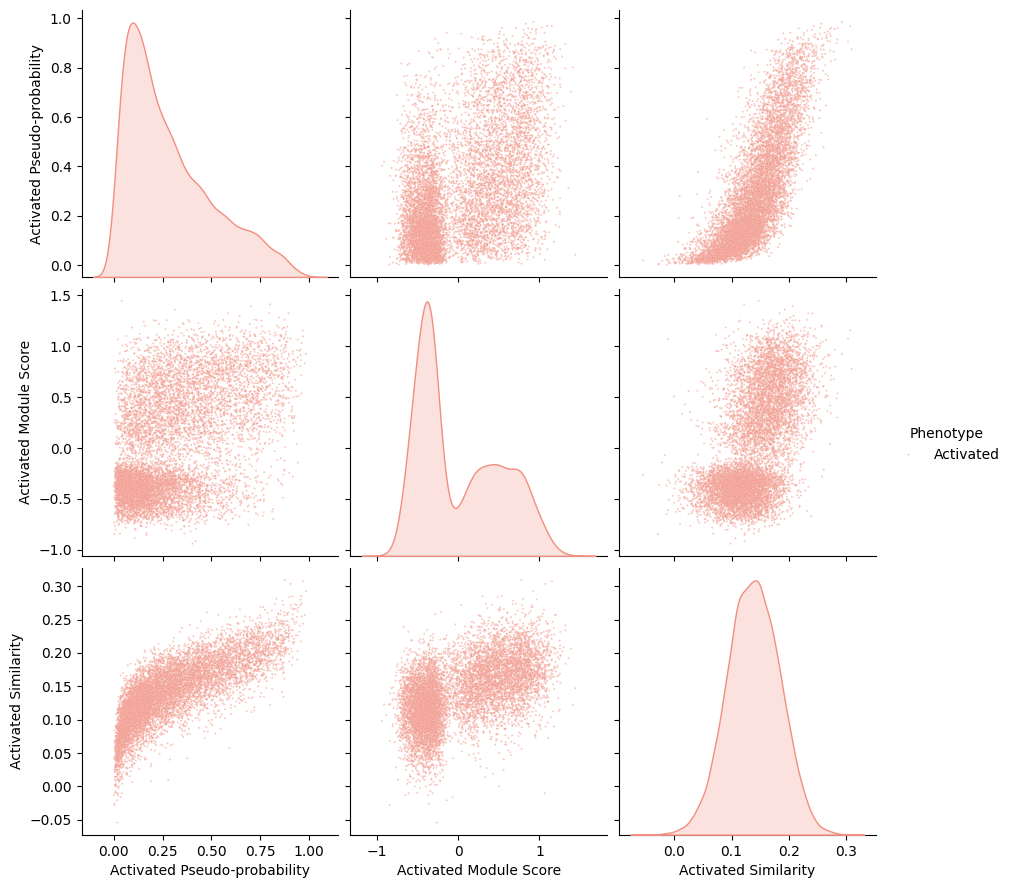

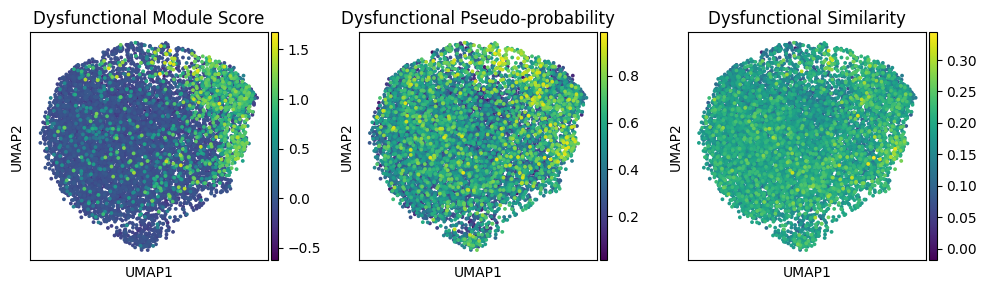

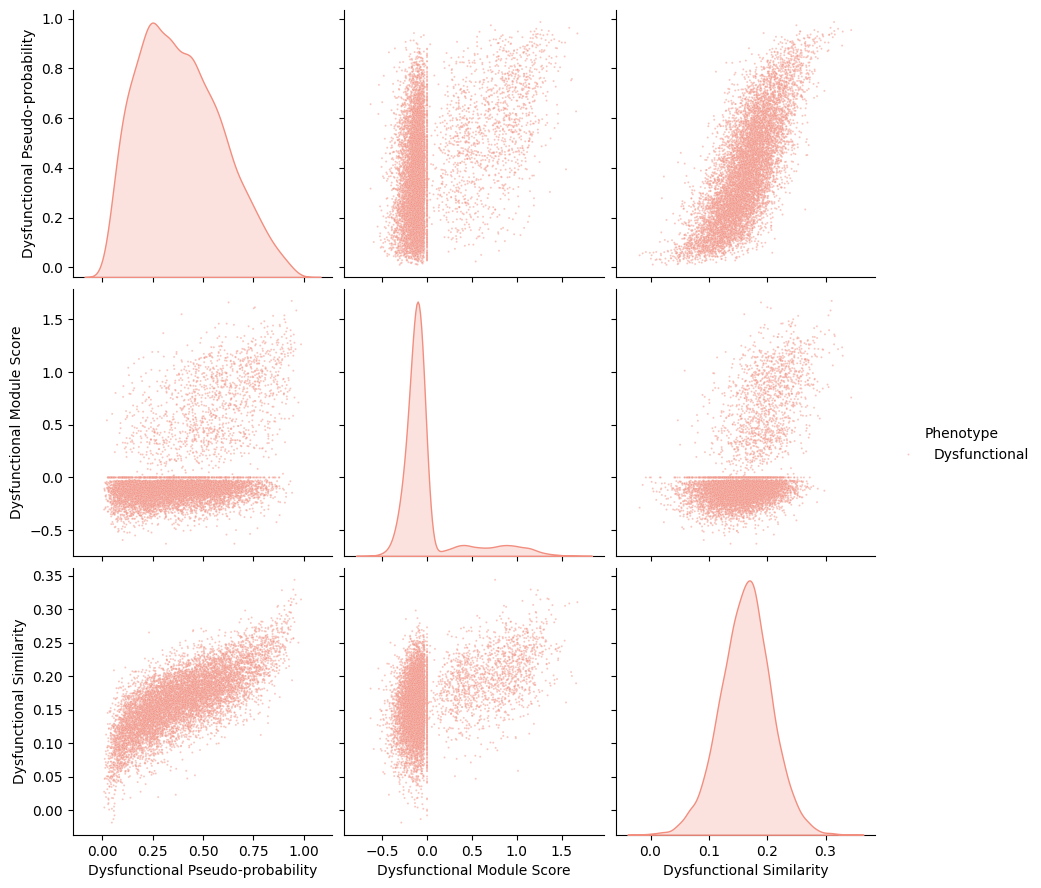

In [170]:
for phenotype, genes  in markers.items():
    cembed.phenotype_qc(adata,phenotype,genes)

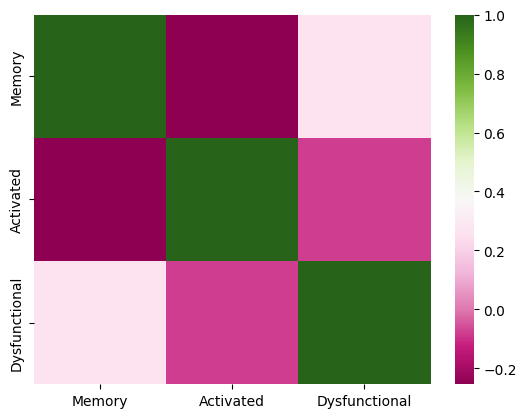

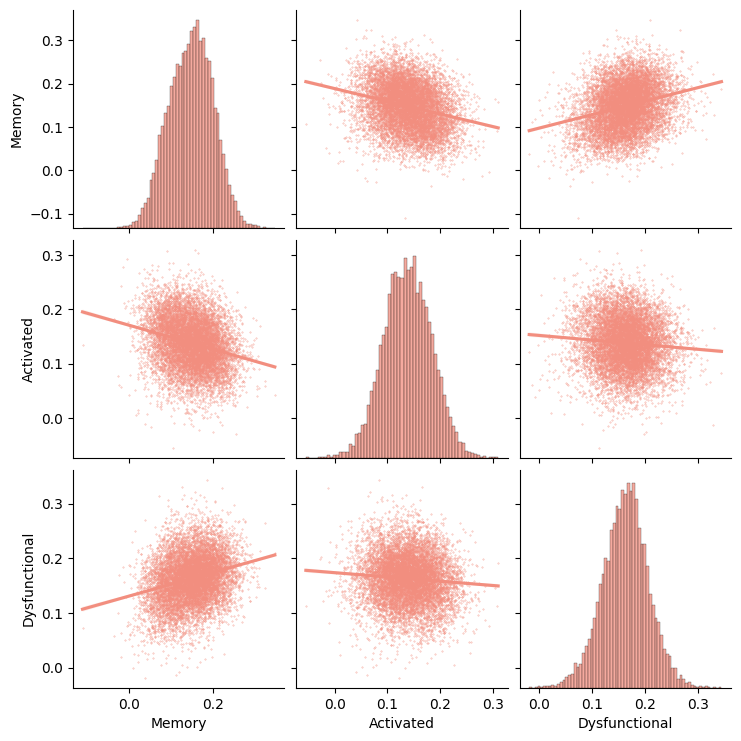

In [171]:
ddf = pd.DataFrame(data = np.array(dist["distances"]),columns=dist['order'])
mat = pd.DataFrame(np.corrcoef(ddf.to_numpy().T),index=dist["order"],columns=dist["order"])
sns.heatmap(mat,cmap="PiYG")
sns.pairplot(data=ddf,kind="reg",plot_kws={"scatter_kws":{"s":0.1}})

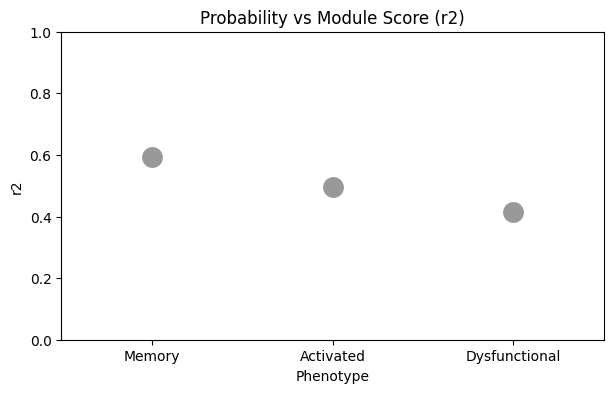

In [172]:
cembed.module_score_r2(adata,markers)

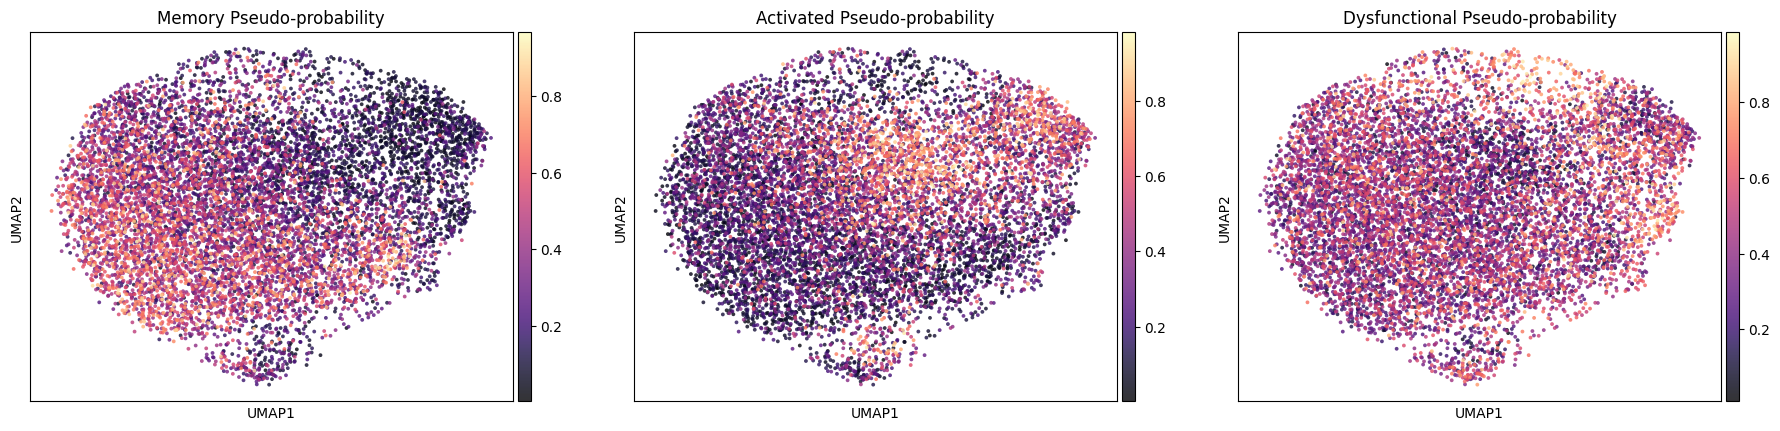

<Figure size 640x480 with 0 Axes>

In [173]:
cembed.plot_probabilities(adata)
plt.savefig("/Users/ceglian/probs.pdf")

In [175]:
tcri.pp.register_phenotype_key(adata,"genevector")
tcri.pp.register_clonotype_key(adata,"trb")

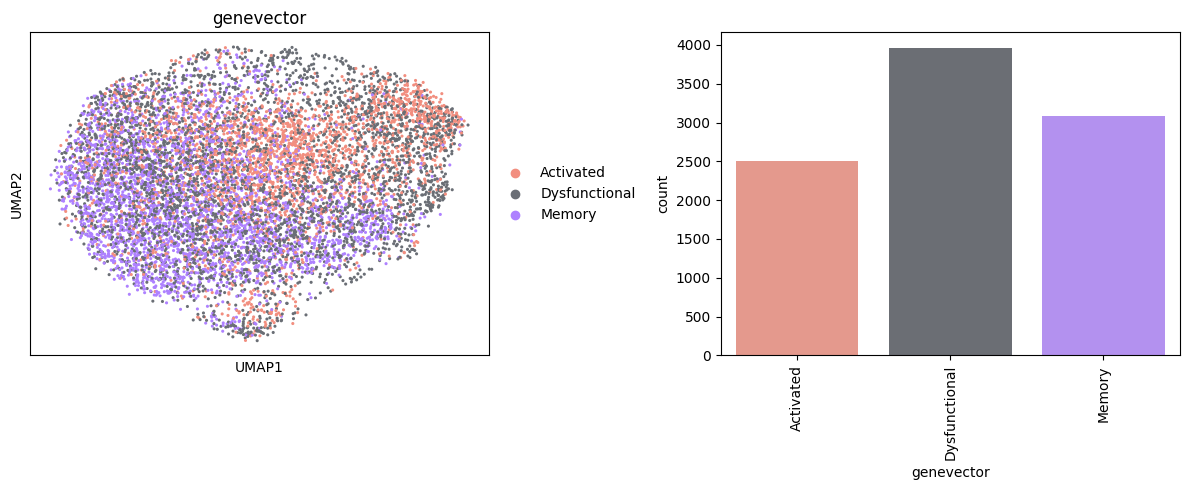

In [176]:
fig,ax = plt.subplots(1,2,figsize=(12,5))
sc.pl.umap(adata,color="genevector",palette=tcri.pl.tcri_colors,s=20, wspace=0.5,ax=ax[0],show=False)
sns.countplot(data=adata.obs,x="genevector",palette=tcri.pl.tcri_colors,ax=ax[1])
plt.xticks(rotation=90)
fig.tight_layout()
fig.savefig("/Users/ceglian/countsgv.pdf")

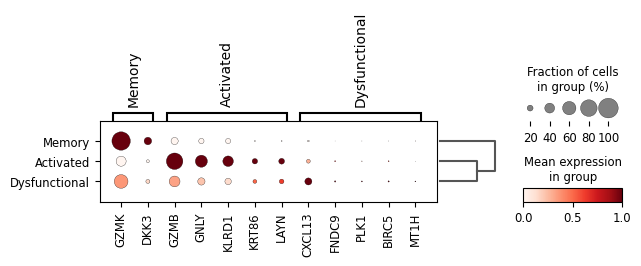

In [177]:
sc.tl.rank_genes_groups(adata,"genevector")
sc.tl.dendrogram(adata,"genevector")
sc.pl.rank_genes_groups_dotplot(adata,min_logfoldchange=1.,standard_scale='var',n_genes=5,save="gv_degs.pdf")
!cp figures/dotplot_gv_degs.pdf ~

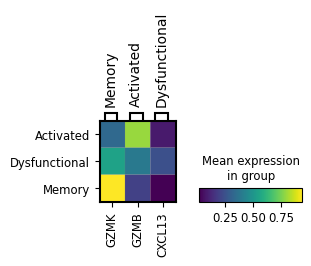

In [178]:
sc.pl.matrixplot(adata,markers,groupby="genevector")

In [179]:
tcri.pp.clone_size(adata)

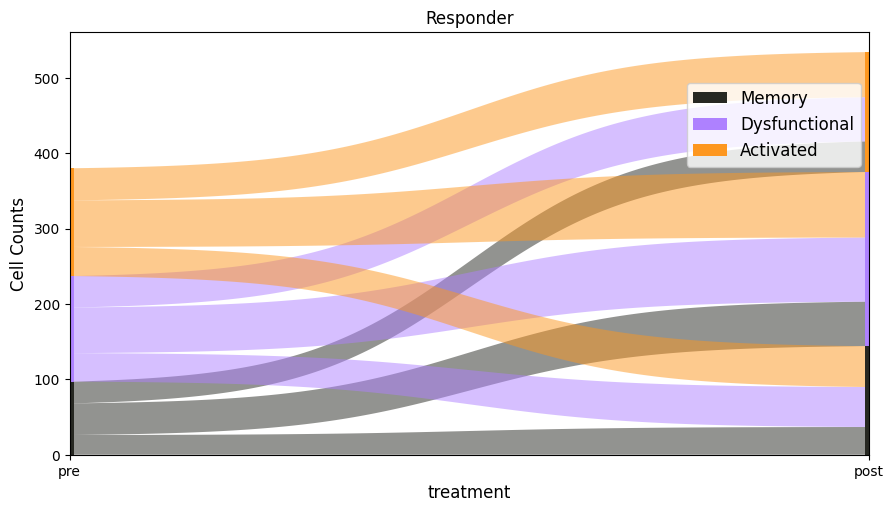

In [183]:
responder = adata[adata.obs["response"] == "Yes"]
responder = responder[responder.obs["clone_size"] > 50]
tcri.pl.phenotypic_flux(responder,splitby="treatment",order=["pre","post"],nt=False,normalize=False)
plt.title("Responder")
plt.savefig("/Users/ceglian/responder_sankey.pdf")

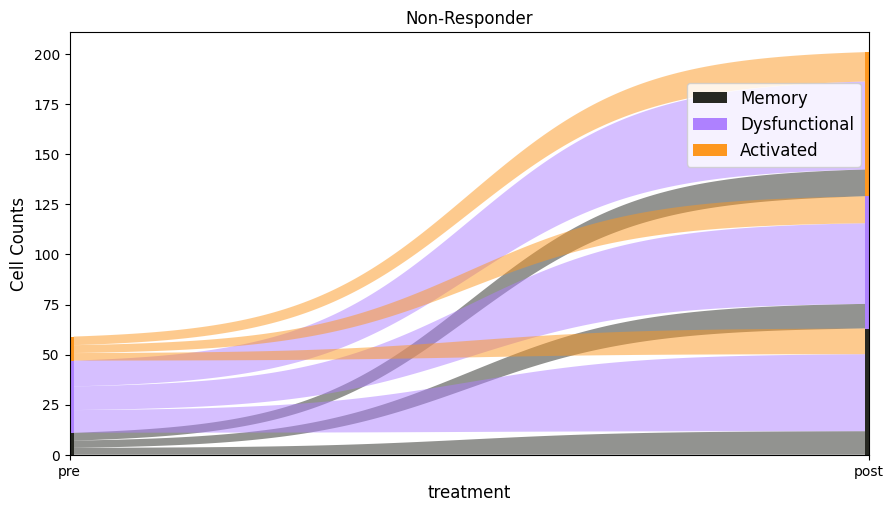

In [184]:
responder = adata[adata.obs["response"] == "No"]
responder = responder[responder.obs["clone_size"] > 50]
tcri.pl.phenotypic_flux(responder,splitby="treatment",order=["pre","post"],nt=False,normalize=False)
plt.title("Non-Responder")
plt.savefig("/Users/ceglian/nrresponder_sankey.pdf")

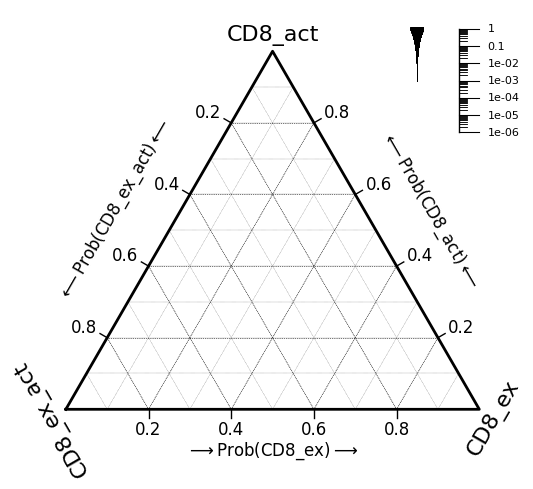

In [99]:
tcri.pl.ternary_plot(adata,phenotype_names=["CD8_act","CD8_ex_act","CD8_ex"],splitby="treatment",condition="pre")

100%|██████████| 11/11 [00:02<00:00,  4.69it/s]


<Axes: xlabel='patient', ylabel='l1'>

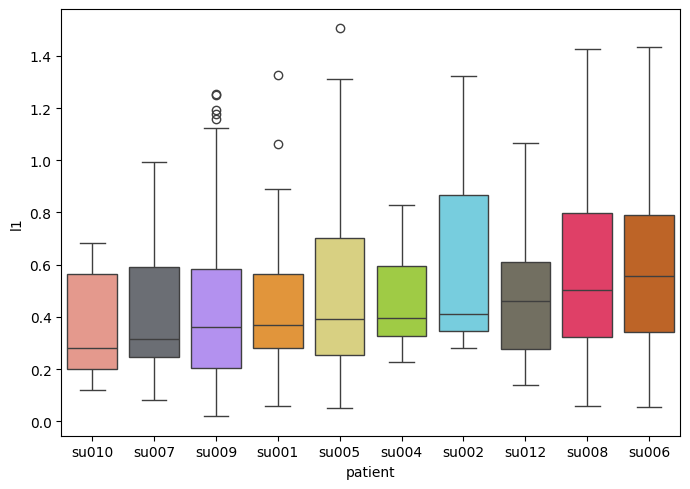

In [100]:
tcri.pl.flux(adata, key="treatment", from_this="pre", to_that="post", groupby="patient", method="probabilistic", distance_metric="l1",figsize=(7,5))

100%|██████████| 11/11 [00:02<00:00,  5.44it/s]


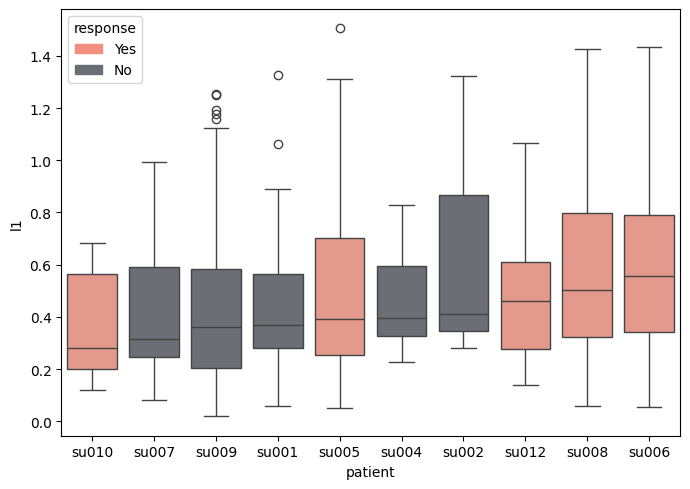

In [101]:
tcri.pl.flux(adata, key="treatment", from_this="pre", to_that="post", groupby="patient", method="probabilistic", distance_metric="l1",paint="response",figsize=(7,5))
plt.savefig("/Users/ceglian/flux_l1.pdf")

100%|██████████| 11/11 [00:02<00:00,  4.13it/s]


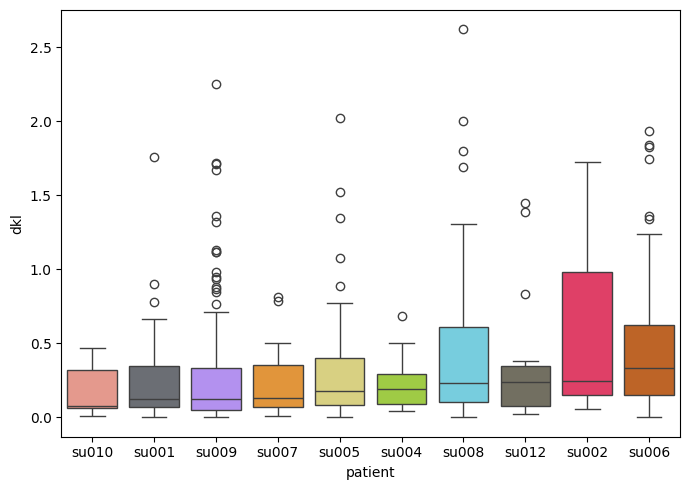

In [102]:
tcri.pl.flux(adata, key="treatment", from_this="pre", to_that="post", groupby="patient", method="probabilistic", distance_metric="dkl",figsize=(7,5))
plt.savefig("/Users/ceglian/flux_dkl.pdf")

100%|██████████| 11/11 [00:01<00:00,  5.89it/s]


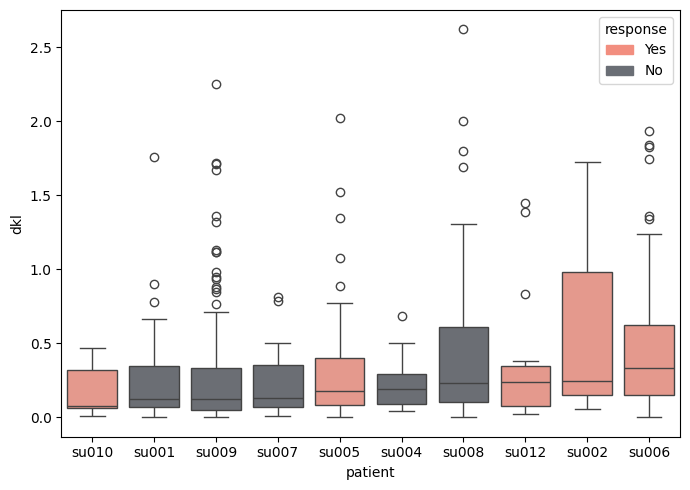

In [103]:
tcri.pl.flux(adata, key="treatment", from_this="pre", to_that="post", groupby="patient",paint="response", method="probabilistic", distance_metric="dkl",figsize=(7,5))
plt.savefig("/Users/ceglian/flux_dkl.pdf")

Text(0.5, 1.0, 'su008')

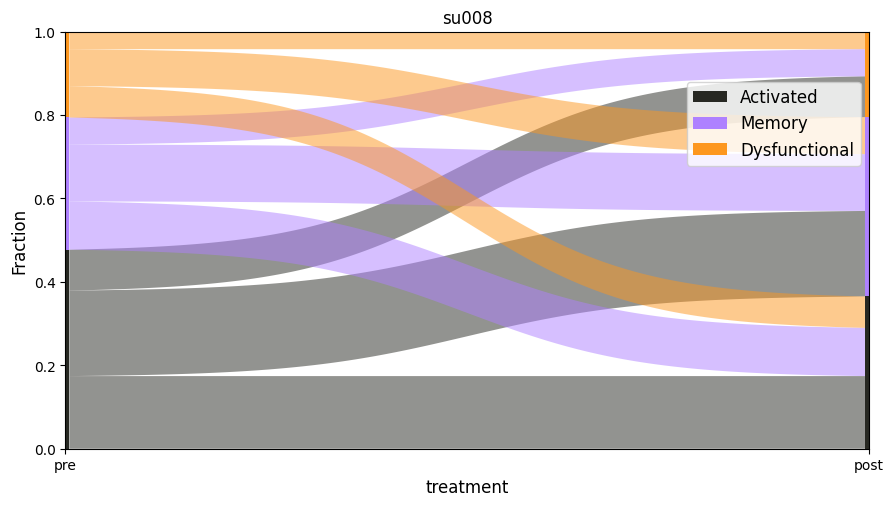

In [104]:
responder = adata[adata.obs["patient"] == "su008"]
responder = responder[responder.obs["clone_size"] > 1]
tcri.pl.phenotypic_flux(responder,splitby="treatment",order=["pre","post"],nt=False)
plt.title("su008")

Text(0.5, 1.0, 'su002')

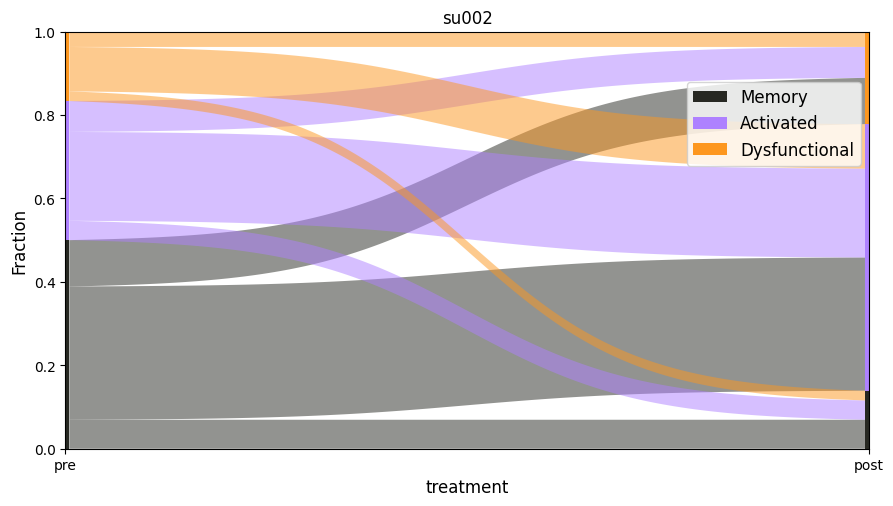

In [105]:
responder = adata[adata.obs["patient"] == "su002"]
responder = responder[responder.obs["clone_size"] > 1]
tcri.pl.phenotypic_flux(responder,splitby="treatment",order=["pre","post"],nt=False)
plt.title("su002")

100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


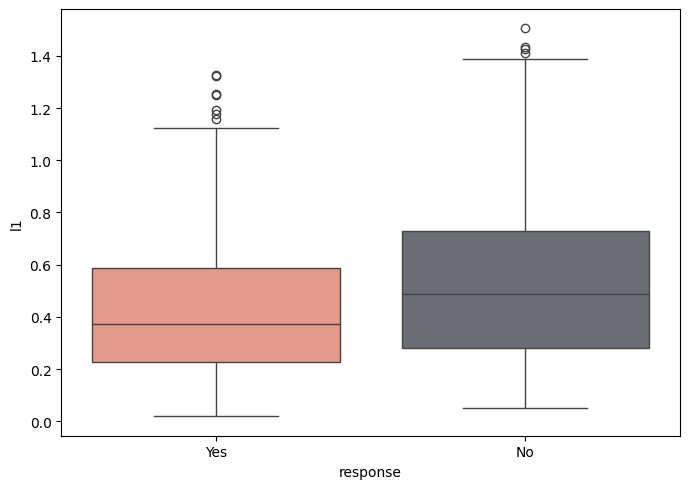

In [106]:
tcri.pl.flux(adata, key="treatment", from_this="pre", to_that="post", groupby="response", method="probabilistic", distance_metric="l1",figsize=(7,5))
plt.savefig("/Users/ceglian/flux_l1_box.pdf")

<Axes: title={'center': 'Clonality'}, xlabel='Phenotype', ylabel='Clonality'>

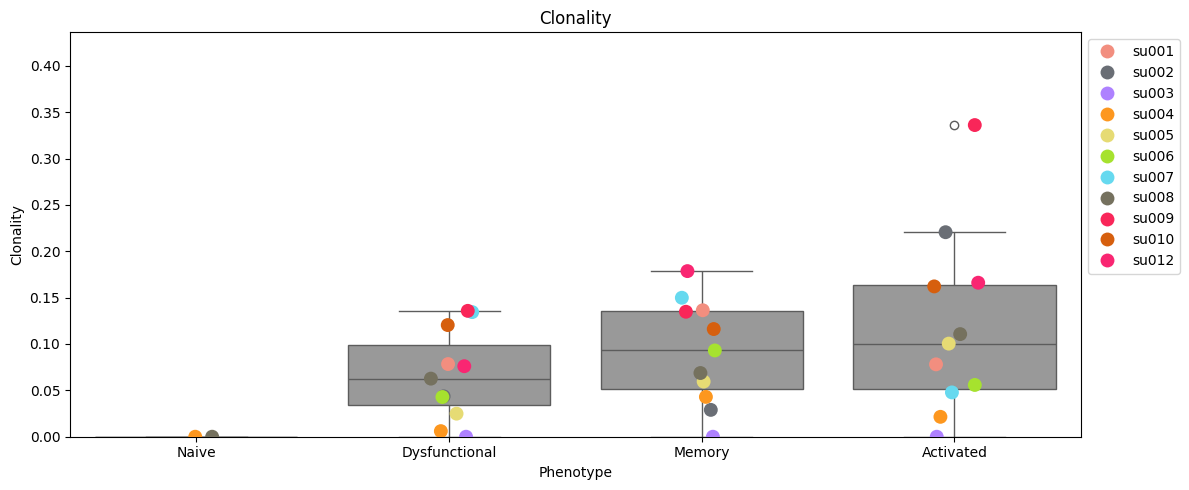

In [107]:
tcri.pl.clonality(adata,groupby="patient")

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:02<00:00,  1.19s/it]


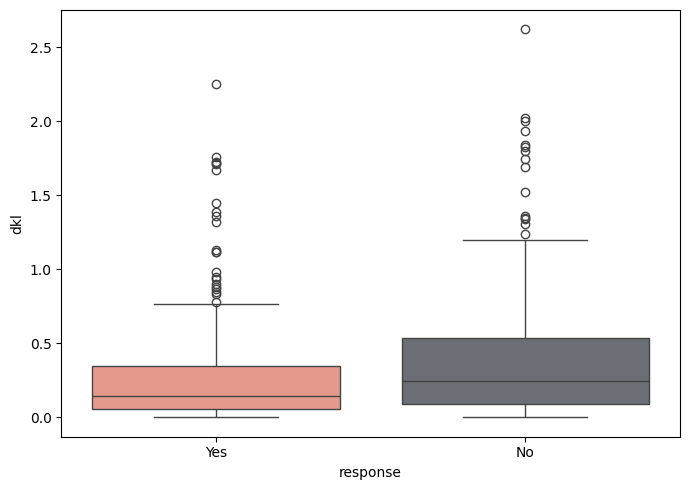

In [108]:
tcri.pl.flux(adata, key="treatment", from_this="pre", to_that="post", groupby="response", method="probabilistic", distance_metric="dkl",figsize=(7,5))
plt.savefig("/Users/ceglian/flux_dkl_box.pdf")

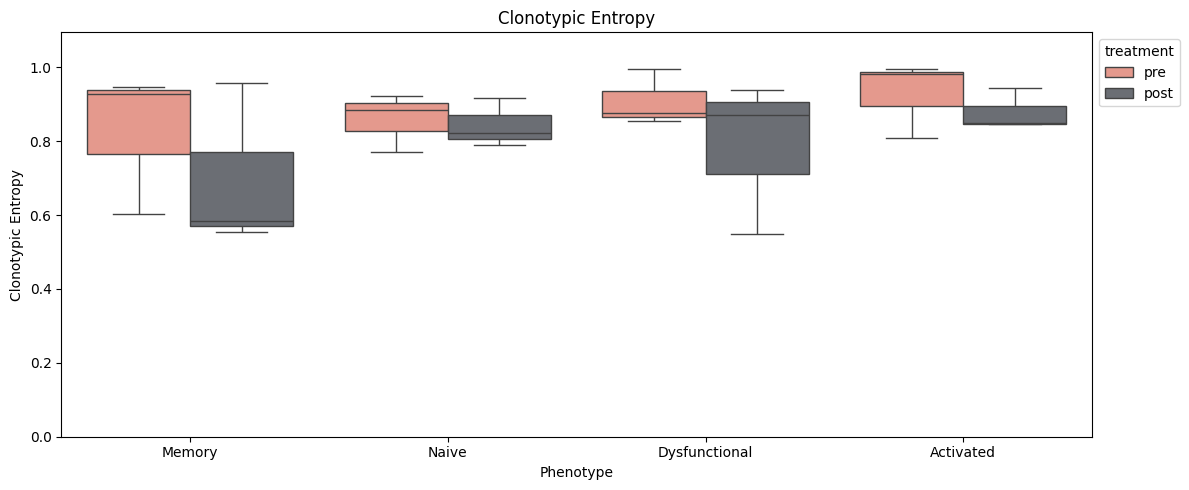

In [109]:
responder= adata[adata.obs["response"] == "Yes"]
responder = responder[responder.obs["clone_size"] > 20]
tcri.pl.clonotypic_entropies(responder, normalized=True, groupby="patient", splitby="treatment", method='probabilistic')
plt.savefig("/Users/ceglian/clono_gv_box_yes.pdf")

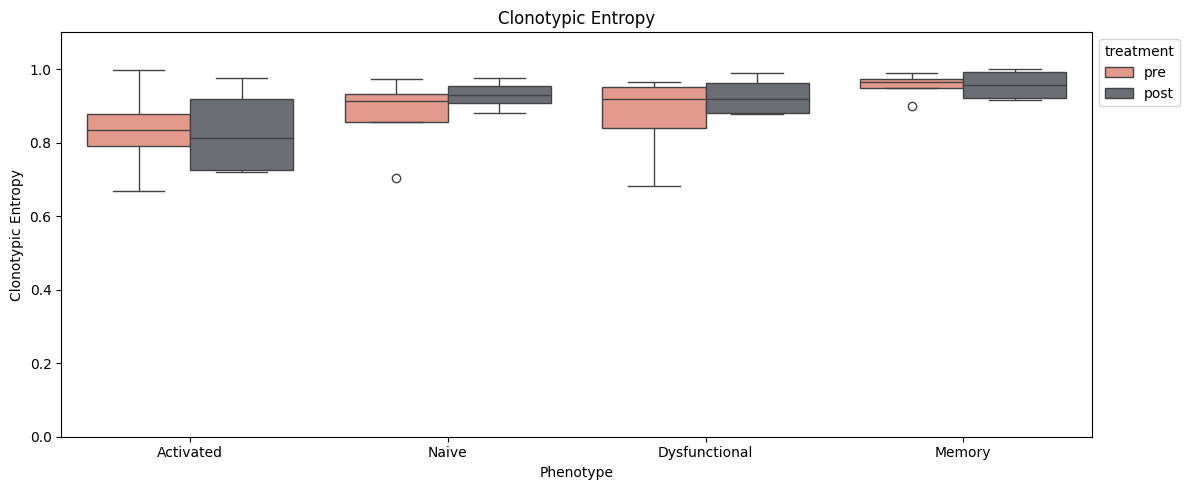

In [110]:
responder= adata[adata.obs["response"] == "No"]
responder = responder[responder.obs["clone_size"] > 20]
tcri.pl.clonotypic_entropies(responder, normalized=True, groupby="patient", splitby="treatment", method='probabilistic')
plt.savefig("/Users/ceglian/clono_gv_box_no.pdf")

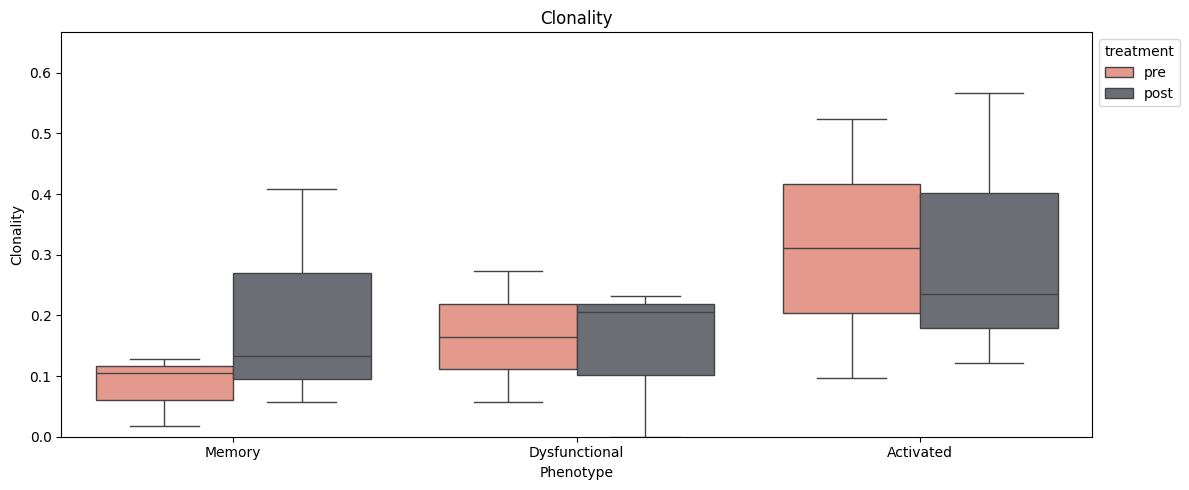

In [111]:
responder= adata[adata.obs["response"] == "Yes"]
responder = responder[responder.obs["clone_size"] > 20]
tcri.pl.clonality(responder, groupby="patient",splitby="treatment", s=10)
plt.savefig("/Users/ceglian/clonality_box_yes.pdf")

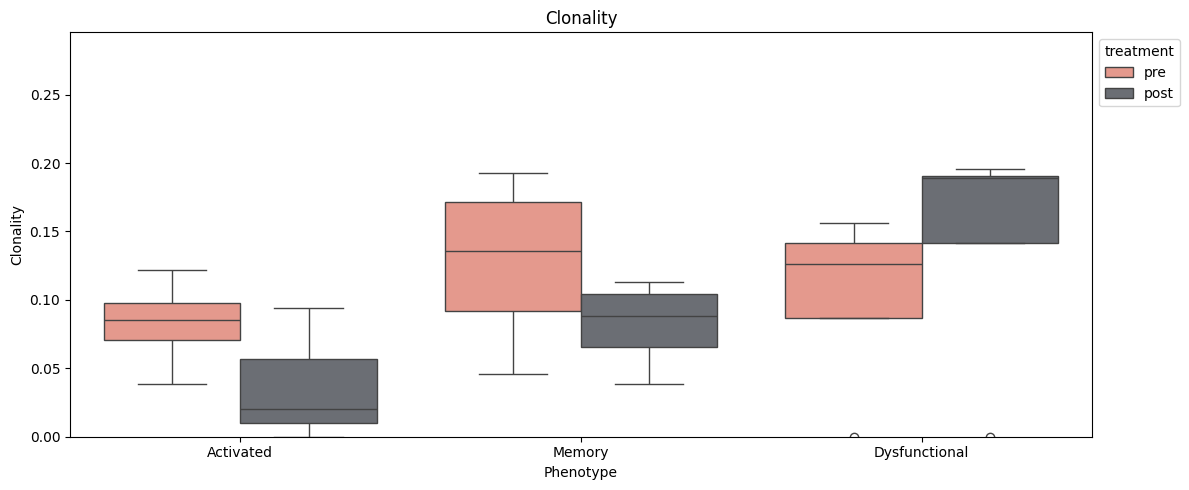

In [112]:
responder= adata[adata.obs["response"] == "No"]
responder = responder[responder.obs["clone_size"] > 20]
tcri.pl.clonality(responder, groupby="patient",splitby="treatment", s=10)
plt.savefig("/Users/ceglian/clonality_box_no.pdf")

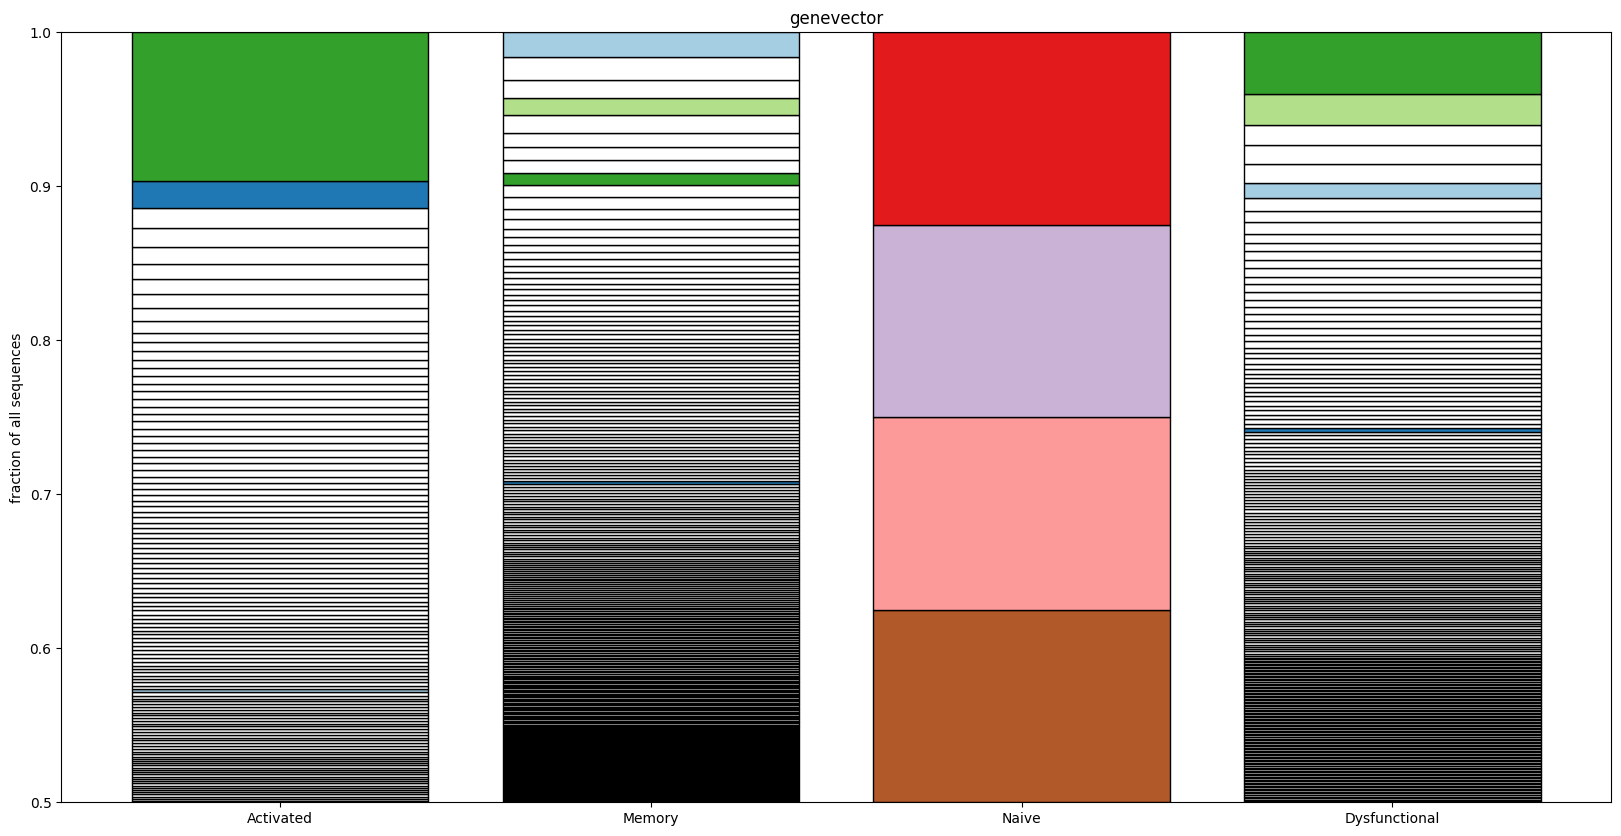

In [113]:
tcri.pl.clone_fraction(adata,"genevector")

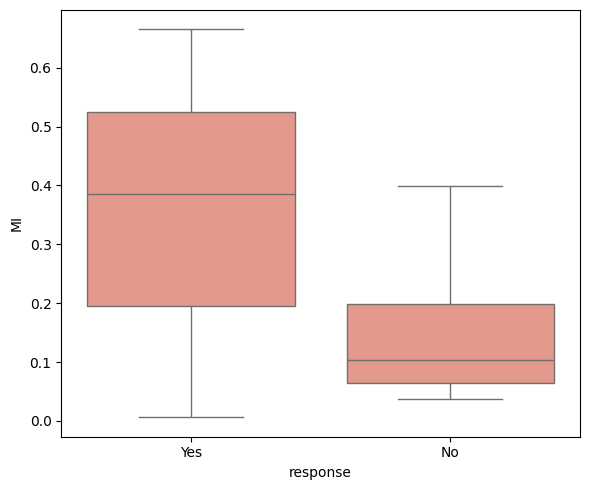

In [43]:
sdata = adata[adata.obs["clone_size"] > 20]
tcri.pl.mutual_information(sdata,groupby="patient",splitby="response")
plt.savefig("/Users/ceglian/mi.pdf")

In [44]:
cls = []
tcr = []
ent = []
size = []
df = adata.obs
for trb, entropy in tcri.tl.phenotypic_entropies(adata,normalized=True).items():
    response = df[df["trb"] == trb]["response"].tolist()[0]
    s =  df[df["trb"] == trb]["clone_size"].tolist()[0]
    tcr.append(trb)
    ent.append(entropy)
    cls.append(response)
    size.append(s)
df = pd.DataFrame.from_dict({"TCR": tcr, "Entropy": ent, "Response":cls,"Sizes":size})
df

TCR   Entropy Response  Sizes
0     CAAGSGLSSPGELFF  4.166406      Yes      1
1       CAARGRVGEKLFF  4.470606       No      1
2       CAARREGTGELFF  3.461165       No      2
3       CACQGFLEETQYF  3.049198       No      2
4     CAGAAERAGADTQYF  3.947209       No      1
...               ...       ...      ...    ...
3694    CSVVSGASNEQYF  0.000000      Yes      1
3695  CSVVYYKGGVYGYTF  0.000000       No      1
3696   CSVWGLAGYNEQFF  0.000000       No      1
3697    CSVYLSRAHEQYF  0.000000       No      1
3698      CTASGEETQYF  0.000000      Yes      2

[3699 rows x 4 columns]

In [45]:

def phenotypic_entropies(adata, method="probabilistic", normalized=False):
    tcri.pp.joint_distribution(adata, method=method)
    unique_tcrs = adata.uns["tcri_unique_clonotypes"]
    jd = adata.uns["joint_distribution"].to_numpy()
    jd = jd / np.sum(jd)
    clonotype_entropies = np.zeros(jd.shape[1])
    max_entropy = np.log(jd.shape[0])
    jd = jd.T
    for i, clonotype_distribution in enumerate(jd):
        normalized_distribution = clonotype_distribution / np.sum(clonotype_distribution)
        epsilon = np.finfo(float).eps
        if normalized:
            clonotype_entropies[i] = -np.sum(normalized_distribution * np.log(normalized_distribution + epsilon)) / max_entropy
        else:
            clonotype_entropies[i] = -np.sum(normalized_distribution * np.log(normalized_distribution + epsilon))
    tcr_to_entropy_dict = dict(zip(unique_tcrs, clonotype_entropies))
    return tcr_to_entropy_dict

df = phenotypic_entropies(adata)
cls = []
tcr = []
ent = []
size = []
pat = []
for p in set(adata.obs["patient"]):
    pdata = adata[adata.obs["patient"] == p].copy()
    tcri.tl.clone_size(pdata)
    response = pdata.obs["response"].tolist()[0]
    df = pdata.obs
    tcri.pp.register_clonotype_key(pdata,"trb")
    for trb, entropy in phenotypic_entropies(pdata,normalized=True).items():
        tdata = pdata[pdata.obs["trb"] == trb]
        s = tdata.obs["clone_size"].tolist()[0]
        tcr.append(trb)
        ent.append(entropy)
        cls.append(response)
        size.append(s)
        pat.append(p)

df = pd.DataFrame.from_dict({"TCR": tcr, "Entropy": ent, "Response":cls, "Sizes":size , "Patient": pat})
df

TCR   Entropy Response  Sizes Patient
0     CAAGSGLSSPGELFF  0.817022      Yes      1   su009
1       CAGAGTANTEAFF  0.568732      Yes      1   su009
2        CAIKSTGNTIYF  0.707155      Yes      1   su009
3     CAILGRRTDQETQYF  0.574438      Yes      2   su009
4      CAIREGGGYNEQFF  0.341678      Yes      1   su009
...               ...       ...      ...    ...     ...
3701   CSASSLARTDTQYF  0.101432      Yes      1   su012
3702   CSVEDSVAGNGYTF  0.156943      Yes      1   su012
3703      CSVEGGAEQYF  0.389030      Yes      1   su012
3704    CSVEGLAVNEQFF  0.435773      Yes      1   su012
3705      CTASGEETQYF  0.138830      Yes      2   su012

[3706 rows x 5 columns]

In [46]:
# df = df[df["Entropy"] > 1.]
# df
df = df[df["Sizes"]]

KeyError: "None of [Index([ 1,  1,  1,  2,  1,  2,  5,  1,  1, 10,\n       ...\n        1,  1,  1,  1,  1,  1,  1,  1,  1,  2],\n      dtype='int64', length=3706)] are in the [columns]"

<Axes: >

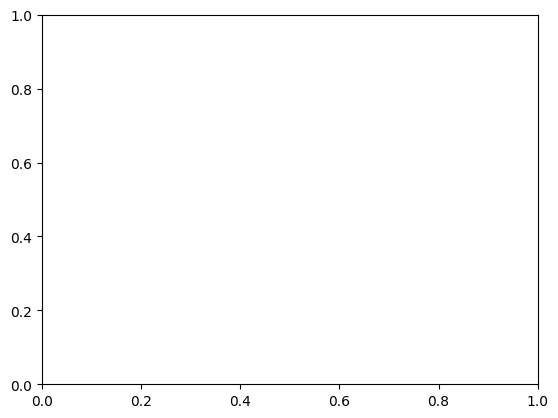

In [275]:
sns.boxplot(data=df,x="Response", y= "Entropy")

<Axes: xlabel='Response', ylabel='count'>

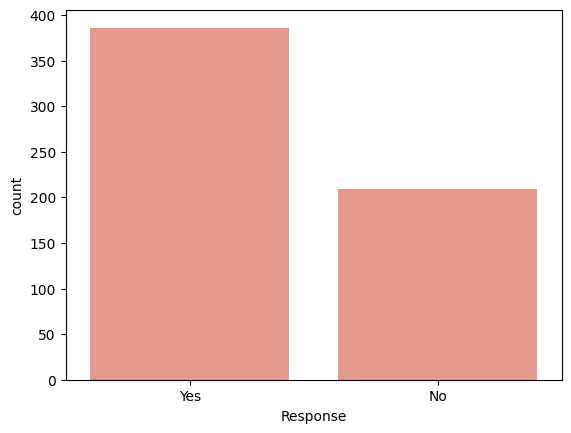

In [268]:
sns.countplot(data=df,x="Response")

<Axes: xlabel='Response', ylabel='Entropy'>

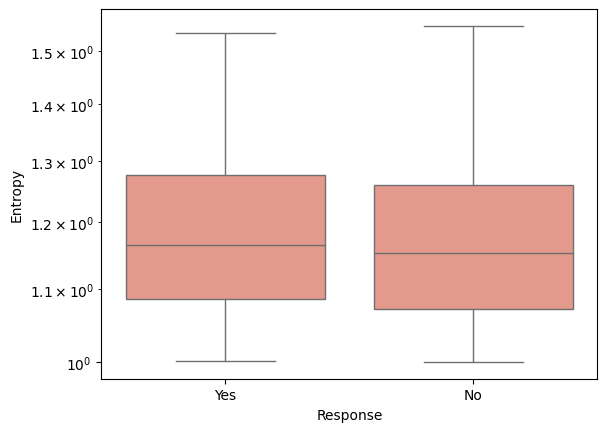

In [270]:
sns.boxplot(data=df, x="Response",y="Entropy",log_scale=True)

In [252]:
dfresp = df[df["Response"] == "Yes"]
dfn = df[df["Response"] == "No"]

In [255]:
dfresp["Entropy"].max()

1.5363418205144457

In [256]:
dfn["Entropy"].max()

1.550274246560155

In [257]:
df[df["Sizes"] > 10]

TCR   Entropy Response  Sizes Patient
159     CASSLIGVSSYNEQFF  1.237382      Yes     13   su012
170        CASSPARNTEAFF  1.097444      Yes     19   su012
473       CSVAGTSVYNEQFF  1.056286       No     18   su005
492       CAISGRGGGAEAFF  1.215637      Yes     15   su009
531        CASQEALGYEQFF  1.014170      Yes     18   su009
650      CASSGGANSGNTIYF  1.020666      Yes     17   su009
697     CASSLAGTSPSNEQFF  1.072701      Yes     27   su009
790      CASSLQRGRTDTQYF  1.043432      Yes     12   su009
833        CASSLVWAKGLFF  1.211845      Yes     21   su009
872       CASSPLSSLTEAFF  1.116460      Yes     19   su009
910       CASSQAPGIDEQFF  1.046832      Yes     29   su009
1345      CASSYWLGGNEQFF  1.018557       No     49   su007
1417         CASRGGTEAFF  1.520923      Yes     15   su002
1441  CATSVGTAGISGANVLTF  1.372888      Yes     14   su002
2492      CATRTPNLVPALYF  1.064934       No     29   su008
2563      CSAPEGGTYNEQFF  1.107933       No     15   su008
2789      CASSLAQGYNEQFF  1.119456       No     24   su006
2817       CASSLGGTGEAFF  1.381740       No     22   su006
2840    CASSLIGVHSTDTQYF  1.107668       No     38   su006
2897    CASSPGQTSSGNTIYF  1.474224       No     21   su006
3017      CASSYTQGNTEAFF  1.320393       No     12   su006
3080      CSARDRGYGNTIYF  1.133319       No     66   su006
3102       CSAVDGYNYGYTF  1.193693       No     19   su006
3146       CASSLGLVQPQHF  1.144455       No     35   su010
3149      CASSLGTVNTEAFF  1.116872       No     20   su010
3180        CASSSVYNEQFF  1.258209       No     37   su010
3233      CASPGQGAAGELFF  1.371012      Yes     22   su001
3266    CASSFAVGGRNTEAFF  1.435128      Yes     12   su001
3289      CASSFTGGLETQYF  1.347029      Yes     11   su001
3466     CASSQEGSAGYEQYF  1.488721      Yes     15   su001
3467     CASSQEGSSGYEQYF  1.374370      Yes     59   su001
3471     CASSQEVTGTYEQYF  1.335053      Yes     17   su001
3507       CASSRVGTNEQFF  1.369668      Yes     12   su001

In [59]:
adata.write("bcc_annotated.h5ad")